In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import bs4 as bs
from shapely.geometry import Point
from matplotlib import pyplot as plt
import json
import os
from requests.structures import CaseInsensitiveDict

## Let's find the areas 5 minutes car/walk distance around beaches
- No beach in OSM, let's use [@B1nj](https://twitter.com/b1nj)'s work to get the beach locations
- Get isochrone (5 minutes) around the beaches
- Show that on the map
- Later: to be extended with real estate.

In [2]:
# put key in env. Get key at: https://www.geoapify.com/isoline-api
GEOAPIFY_KEY = os.environ['GEOAPIFY_KEY']

# reuse downloaded files
reload = False

COMMUNES_FILES = 'data/communes-martinique.geojson'

In [3]:
entry_page = bs.BeautifulSoup(requests.get('http://www.plages.mq/').text)
plage_urls = [elt.a.get('href') for elt in entry_page.find_all(class_='item-detail')]

In [4]:
if reload:
    plages = []
    for plage_url in plage_urls:
        plage = bs.BeautifulSoup(requests.get(plage_url).text)
        plage_lat = float(plage.find('meta', attrs={"property": "place:location:latitude"}).get('content'))
        plage_lon = float(plage.find('meta', attrs={"property": "place:location:longitude"}).get('content'))
        plage_rating = float(plage.find('meta', attrs={"itemprop": "ratingValue"}).get('content'))
        plage_title = plage.find('title').text
        plage_shortname = plage.find(class_='content-titre').span.text
        plages.append([plage_title, plage_shortname, plage_lat, plage_lon, plage_rating])

    # save it to not call the websites too much
    with open('data/plages-mq.json', 'w') as w:
        w.write(json.dumps(plages))
else:
    with open('data/plages-mq.json') as r:
        plages = json.load(r)

In [5]:
isolines = {}
for how in ['walk', 'drive']:
    if reload:
        isolines[how] = []
        for plage_title, plage_shortname, plage_lat, plage_lon, plage_rating in plages:
            print(plage_title)
            url = f"https://api.geoapify.com/v1/isoline?lat={plage_lat}&lon={plage_lon}&type=time&mode={how}&range=300&apiKey={GEOAPIFY_KEY}"
            headers = CaseInsensitiveDict()
            headers["Accept"] = "application/json"
            resp = requests.get(url, headers=headers)
            isolines[how].append(resp.json())
            # save it to not call the websites too much
            with open(f'data/plages-mq-isolines-5min-{how}.json', 'w') as w:
                w.write(json.dumps(isolines[how]))
    else:
        with open(f'data/plages-mq-isolines-5min-{how}.json') as r:
            isolines[how] = json.load(r)

In [6]:
gdf = gpd.read_file(COMMUNES_FILES)

merged_isolines_walk = {"features": [], 'type': 'FeatureCollection'}
for iso in isolines['walk']:
    merged_isolines_walk["features"] += iso["features"]
gdf_isolines_walk = gpd.GeoDataFrame.from_features(merged_isolines_walk)


merged_isolines_drive = {"features": [], 'type': 'FeatureCollection'}
for iso in isolines['drive']:
    merged_isolines_drive["features"] += iso["features"]
gdf_isolines_drive = gpd.GeoDataFrame.from_features(merged_isolines_drive)

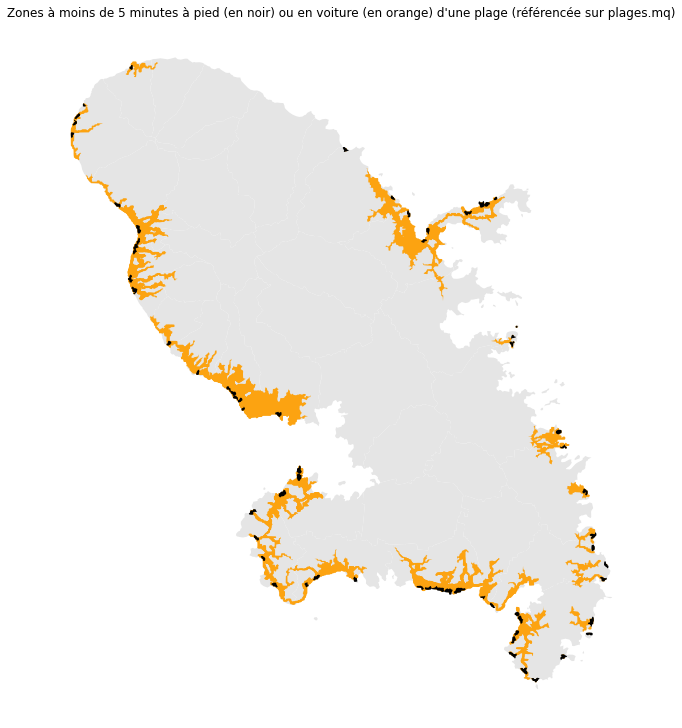

In [7]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))
fig.suptitle("Zones à moins de 5 minutes à pied (en noir) ou en voiture (en orange) d'une plage (référencée sur plages.mq)",
             backgroundcolor='white', color='black')

ax = gdf.plot(ax=ax, color="#e5e5e5")
gdf_isolines_drive.plot(ax=ax, color="#fca311")
gdf_isolines_walk.plot(ax=ax, color="#000000")
ax.axis('off')

plt.savefig('output/2022-11-13.png', facecolor='white')